In [104]:
# Global imports
%load_ext autoreload

# import csv
import numpy
import pickle
import pandas
from tqdm import tqdm
import random
from collections import Counter

import matplotlib.pyplot as plt
from IPython.display import HTML, display, Image

import sys
import os

model_file="pokemon_classification_model_4"
image_output_directory = os.path.abspath("../Datasets/Pokemon/AugmentedImages")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Loading stats from CSV file

In [106]:
csv_file = "../Datasets/Pokemon/pokemon_alopez247.csv"
with open(csv_file, 'r') as f:
    statistics = pandas.read_csv(f)
# print(statistics.columns.values)

pokemon_names = list(statistics["Name"])
cat_to_label = {cat:i for i,cat in enumerate(pokemon_names)}
label_to_cat = {i:cat for i,cat in enumerate(pokemon_names)}

pokemon_subset = list(statistics[statistics["Generation"]==1]["Name"])[:10]
print("Pokemons : "+str(len(pokemon_subset)))

Pokemons : 10


# Preparing datasets

In [107]:
training_images = []
training_labels = []
testing_images = []
testing_labels = []

for pokemon in pokemon_subset:
    directory = image_output_directory + "/" + pokemon + "/"
    files = [f for f in os.listdir(directory) if f.endswith("jpg") or f.endswith("png")]
    random.shuffle(files)
    
    num_files = len(files)
    num_training_files = int(numpy.floor(num_files * 0.9))
    training_files = files[:num_training_files]
    testing_files = files[num_training_files:]
    
    training_images += [os.path.abspath(directory+f) for f in training_files]
    training_labels += [cat_to_label[pokemon] for f in training_files]
    
    testing_images += [os.path.abspath(directory+f) for f in testing_files]
    testing_labels += [cat_to_label[pokemon] for f in testing_files]

    
print("Number of training files in total : "+str(len(training_images)))
print("Number of testing files in total : "+str(len(testing_images)))

Number of training files in total : 37008
Number of testing files in total : 4112


In [108]:
%autoreload 2
import data_processing as DP

# Shuffling train images
perm = numpy.random.permutation(len(training_images))
shuffled_train_images = numpy.array(training_images)[perm]
shuffled_train_labels = numpy.array(training_labels)[perm]
shuffled_train_categories = [label_to_cat[l] for l in shuffled_train_labels]

perm = numpy.random.permutation(len(testing_images))
shuffled_test_images = numpy.array(testing_images)[perm]
shuffled_test_labels = numpy.array(testing_labels)[perm]
shuffled_test_categories = [label_to_cat[l] for l in shuffled_test_labels]

train_examples = DP.get_image_dataframe(
    shuffled_train_images, shuffled_train_labels, shuffled_train_categories, 32, 
    "../Datasets/Pokemon/train_aug.pkl", image_output_directory
    )

test_examples = DP.get_image_dataframe(
    shuffled_test_images, shuffled_test_labels, shuffled_test_categories, 32,
    "../Datasets/Pokemon/test_aug.pkl", image_output_directory
    )

Image to vector : 100%|██████████| 4112/4112 [00:14<00:00, 276.19it/s]


# Loading vectors and creating training and testing sets

In [65]:
%autoreload 2
import classification as CL

# We only keep classes classes with label under max_class
max_class = 12

training_examples = pandas.read_pickle("../Datasets/Pokemon/train_3.pkl")
training_examples = training_examples[training_examples.Labels < max_class]
    
X_train = numpy.transpose(numpy.array(training_examples.filter(regex="X")))
Y_train = numpy.array(training_examples["Labels"])
print("X_train : " +str(X_train.shape))
print("Y_train : " +str(Y_train.shape))

testing_examples = pandas.read_pickle("../Datasets/Pokemon/test_3.pkl")
testing_examples = testing_examples[testing_examples.Labels < max_class]

X_test = numpy.transpose(numpy.array(testing_examples.filter(regex="X")))
Y_test = numpy.array(testing_examples["Labels"])
print("X_test : " +str(X_test.shape))
print("Y_test : " +str(Y_test.shape))

# We normalize the data.
X_train = X_train / 255 
X_test = X_test / 255 
X_train, X_test = CL.normalizing_features(X_train, X_test)

X_train : (1024, 5467)
Y_train : (5467,)
X_test : (1024, 628)
Y_test : (628,)


In [72]:
%autoreload 2
import classification as CL

# We convert labels into one-hot matrix
num_classes = int(numpy.max(Y_train)) + 1
Y_train_oh = CL.one_hot_matrix(Y_train, num_classes)
print("One hot : "+str(Y_train_oh.shape))

num_features = X_train.shape[0]
num_examples = X_train.shape[1]
num_classes = Y_train_oh.shape[0]
print("Number of features : "+str(num_features))
print("Number of train examples : "+str(num_examples))
print("Number of classes : "+str(num_classes)+"\n")

# Hyperparameters :
n_l = [num_features, 20,20, num_classes]

One hot : (30, 5467)
Number of features : 1024
Number of train examples : 5467
Number of classes : 30



# Training model

In [73]:
%autoreload 2
import classification as CL

# Training model with adam optimization
parameters, costs = CL.nn_model(
    X_train, Y_train_oh, n_l,
    initialization="relu", opt_fnct="adam", 
    learning_rate=0.01, lambda_param=0.1, num_iterations=500, print_cost=100, model_file=model_file
)

Cost after iteration 1 : 3.614788725783178
Cost after iteration 101 : 2.8807249228907406
Cost after iteration 201 : 2.2462382856142766
Cost after iteration 301 : 1.8931599420862055
Cost after iteration 401 : 1.7201515485466978
Cost after all iterations : 1.5228560696829991



In [101]:
%autoreload 2
import classification as CL

trained_model = numpy.load(model_file+".npy").item()

parameters, costs = CL.nn_model(
    X_train, Y_train_oh, n_l,
    previous_parameters=trained_model, opt_fnct="adam",
    learning_rate=0.0001, lambda_param=0.1, num_iterations=2000, print_cost=200, model_file=model_file
)

Continuing from previous parameters.
Cost after iteration 1 : 0.8708998681249283
Cost after iteration 201 : 0.8704796823914133
Cost after iteration 401 : 0.8701256659080068
Cost after iteration 601 : 0.8699845123681159
Cost after iteration 801 : 0.869542189573479
Cost after iteration 1001 : 0.8691735074091913
Cost after iteration 1201 : 0.8685138651920651


/Users/emiliepicardcantin/Documents/Coursera/NeuralNetwork/Code/classification.py:208: RuntimeWarning: divide by zero encountered in log
  t = np.log(A_L)


Cost after iteration 1401 : 0.8678580323532078
Cost after iteration 1601 : 0.8673132874977402
Cost after iteration 1801 : 0.8669197309406684
Cost after all iterations : 0.8665344307604969



# Evaluating model

## On training set

In [102]:
%autoreload 2
import classification as CL
import data_processing as DP

trained_model = numpy.load(model_file+".npy").item()

num_train_examples = len(Y_train)
print("Total number of train examples : "+str(num_train_examples))

predictions, A_L = CL.predict(trained_model["parameters"], X_train, len(n_l)-1, last_act_fnct="softmax") * 1

Total number of train examples : 5467


Number of correctly classified train examples : 4130
Number of wrongly classified train examples : 1337
Number of wrongly classified examples by label : {'Butterfree': 24, 'Caterpie': 59, 'Metapod': 58, 'Ekans': 33, 'Rattata': 47, 'Raichu': 48, 'Spearow': 38, 'Pikachu': 38, 'Sandslash': 41, 'Weedle': 59, 'Raticate': 45, 'Squirtle': 17, 'Nidorina': 63, 'Sandshrew': 50, 'Kakuna': 34, 'Wartortle': 58, 'Fearow': 27, 'Charmander': 46, 'Pidgeot': 55, 'Arbok': 34, 'Bulbasaur': 51, 'Beedrill': 44, 'Pidgey': 69, 'Venusaur': 46, 'Ivysaur': 33, 'Blastoise': 46, 'Pidgeotto': 56, 'Nidoran♀': 56, 'Charmeleon': 39, 'Charizard': 23}


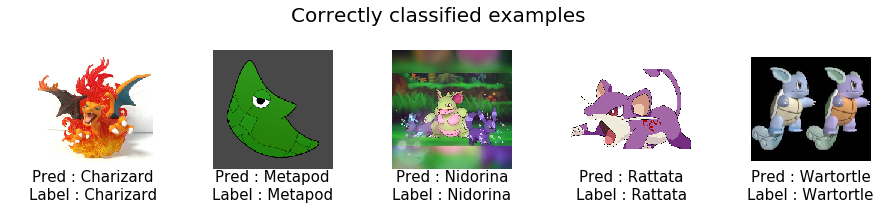

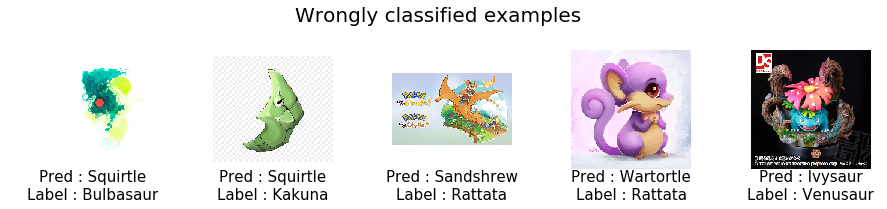

In [103]:
# Display images correctly classified.
correctly_classified_train_examples = numpy.arange(num_train_examples)[predictions == Y_train]
print("Number of correctly classified train examples : "+str(len(correctly_classified_train_examples)))

# numpy.random.seed(42)
images_indices = numpy.random.choice(correctly_classified_train_examples, 5, replace=False)
train_files = numpy.array(training_examples["Files"])[images_indices]
# print(images_indices)
# print(type(training_examples["Files"]))
# print(numpy.array(training_examples["Files"]))
files = [os.path.relpath(os.path.abspath(image_output_directory)+f) for f in train_files]
captions_pred = [label_to_cat[l] for l in predictions[images_indices]]
captions_lab = [label_to_cat[l] for l in Y_train[images_indices]]

fig = plt.figure(figsize=(15,3))
subplots = fig.subplots(1, len(files))
fig.subplots_adjust(wspace=0.5)
fig.suptitle("Correctly classified examples", fontsize=20, verticalalignment="top")
for i, image in enumerate(files):
    sub = subplots[i]
    sub.set_title("Pred : "+captions_pred[i]+"\nLabel : "+captions_lab[i], verticalalignment="top", y=-0.05, fontsize=15)
    sub.imshow(numpy.array(DP.make_square(image)))
    sub.axis('off')

# Display images wrongly classified.
wrongly_classified_train_examples = numpy.arange(num_train_examples)[predictions != Y_train]
print("Number of wrongly classified train examples : "+str(len(wrongly_classified_train_examples)))
wce_by_cat = Counter(Y_train[wrongly_classified_train_examples])
wce_by_cat = {label_to_cat[l]:count for l,count in wce_by_cat.items()}
print("Number of wrongly classified examples by label : "+str(wce_by_cat))

# numpy.random.seed(42)
images_indices = numpy.random.choice(wrongly_classified_train_examples, 5, replace=False)
train_files = numpy.array(training_examples["Files"])[images_indices]
files = [os.path.relpath(os.path.abspath(image_output_directory)+f) for f in train_files]
captions_pred = [label_to_cat[l] for l in predictions[images_indices]]
captions_lab = [label_to_cat[l] for l in Y_train[images_indices]]

fig = plt.figure(figsize=(15,3))
subplots = fig.subplots(1, len(files))
fig.subplots_adjust(wspace=0.5)
fig.suptitle("Wrongly classified examples", fontsize=20, verticalalignment="top")
columns = 3
for i, image in enumerate(files):
    sub = subplots[i]
    sub.set_title("Pred : "+captions_pred[i]+"\nLabel : "+captions_lab[i], verticalalignment="top", y=-0.05, fontsize=15)
    sub.imshow(numpy.array(DP.make_square(image)))
    sub.axis('off')

In [ ]:
import matplotlib.image as mpimg
from PIL import Image as Ipil
%matplotlib inline

%autoreload 2
import data_processing as DP

paras = "../Datasets/Pokemon/Images/Paras/latest?cb=20091127021125.jpg"
machamp = '../Datasets/Pokemon/Images/Machamp/latest?cb=20180103014132.jpg'
alakazam = '../Datasets/Pokemon/Images/Alakazam/latest?cb=20170824203703.jpg'

categories = ["Paras", "Machamp", "Alakazam"]
images = [paras, machamp, alakazam]
    
fig = plt.figure(figsize=(10,3))
subplots = fig.subplots(1, len(images))
fig.subplots_adjust(wspace=0.5)
columns = 3
for i, image in enumerate(images):
    sub = subplots[i]
    sub.set_title(categories[i], verticalalignment="top", y=1.2, fontsize=15)
    sub.imshow(numpy.array(DP.make_square(image)))
    sub.axis('off')

In [ ]:


# score_details,f1_details = CL.compute_f1_score_multi_class(predictions, Y_train[0], num_classes)

# num_images_per_label = Counter(Y_train[0])

# y = [details["f1_score"] for details in f1_details]
# y_labels = [i for i in range(len(f1_details))]
# tick_labels = [label_to_cat[i] for i in y_labels]

# num_data_to_keep = 60
# offset_data = 0
# sort_order = numpy.argsort(y)
# selection = range(offset_data, offset_data+num_data_to_keep)
# y = numpy.array(y)[sort_order][selection]
# y_labels = numpy.array(y_labels)[sort_order][selection]
# tick_labels = numpy.array(tick_labels)[sort_order][selection]
# x = range(num_data_to_keep)

# fig, ax = plt.subplots() 
# fig.set_figwidth(20)
# ax.bar(x,y, width=0.6)
# ax.set_xticks(x)
# ax.set_xticklabels(labels=tick_labels, rotation=90)
# plt.show()

# df = pandas.DataFrame.from_dict(score_details[15]).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
# display(HTML(df.to_html()))

# df2 = pandas.DataFrame.from_dict(f1_details[15], orient='index', columns=["Global"])
# display(HTML(df2.to_html()))

# print("Label : "+str(label_to_cat[15]))

## On testing set

In [ ]:
%autoreload 2
import classification as CL

trained_model = numpy.load(model_file+".npy").item()

predictions, A_L = CL.predict(trained_model["parameters"], X_test, len(n_l)-1, last_act_fnct="softmax")

# Display images wrongly classified.
num_test_examples = len(Y_test[0])
print("Total number of test examples : "+str(num_test_examples))
wrongly_classified_examples = numpy.arange(num_test_examples)[predictions != Y_test[0]]
print("Number of wrongly classified examples : "+str(len(wrongly_classified_examples)))
images_indices = numpy.random.choice(wrongly_classified_examples, 5, replace=False)
print("Images to display : "+str(images_indices))


# score_details,f1_details = CL.compute_f1_score_multi_class(predictions, Y_test[0], num_classes)

# num_images_per_label = Counter(Y_test[0])

# y = [details["f1_score"] for details in f1_details]
# y_labels = [i for i in range(len(f1_details))]
# tick_labels = [label_to_cat[i] for i in y_labels]

# num_data_to_keep = 60
# offset_data = 0
# sort_order = numpy.argsort(y)
# sort_order = list(range(num_data_to_keep))
# selection = range(offset_data, offset_data+num_data_to_keep)
# y = numpy.array(y)[sort_order][selection]
# y_labels = numpy.array(y_labels)[sort_order][selection]
# tick_labels = numpy.array(tick_labels)[sort_order][selection]
# x = range(num_data_to_keep)

# fig, ax = plt.subplots() 
# fig.set_figwidth(20)
# ax.bar(x,y, width=0.6)
# ax.set_xticks(x)
# ax.set_xticklabels(labels=tick_labels, rotation=90)
# plt.show()

# i=0
# print(f1_details[i])
# df = pandas.DataFrame.from_dict(score_details[i]).reindex(["labels", "predictions", "true_predictions", "false_predictions"])
# display(HTML(df.to_html()))

# df2 = pandas.DataFrame.from_dict(f1_score, orient='index', columns=["Global"])
# display(HTML(df2.to_html()))